Using device: cuda
Starting round 1/25
Round 1 - Entropy: 5.781594276428223, Loss: 0.03615530815124512, Accuracy: 0.1
Completed round 1/25
Starting round 2/25
Round 2 - Entropy: 6.049176216125488, Loss: 0.03507738833427429, Accuracy: 0.1049
Completed round 2/25
Starting round 3/25
Round 3 - Entropy: 6.138022422790527, Loss: 0.0193774222612381, Accuracy: 0.5458
Completed round 3/25
Starting round 4/25
Round 4 - Entropy: 5.8368635177612305, Loss: 0.015151279628276825, Accuracy: 0.6362
Completed round 4/25
Starting round 5/25
Round 5 - Entropy: 5.652361869812012, Loss: 0.012654870718717575, Accuracy: 0.699
Completed round 5/25
Starting round 6/25
Round 6 - Entropy: 5.598933219909668, Loss: 0.011342439967393874, Accuracy: 0.7274
Completed round 6/25
Starting round 7/25
Round 7 - Entropy: 5.548436641693115, Loss: 0.010532131737470626, Accuracy: 0.7437
Completed round 7/25
Starting round 8/25
Round 8 - Entropy: 5.523830413818359, Loss: 0.01007169588804245, Accuracy: 0.7539
Completed round 8/

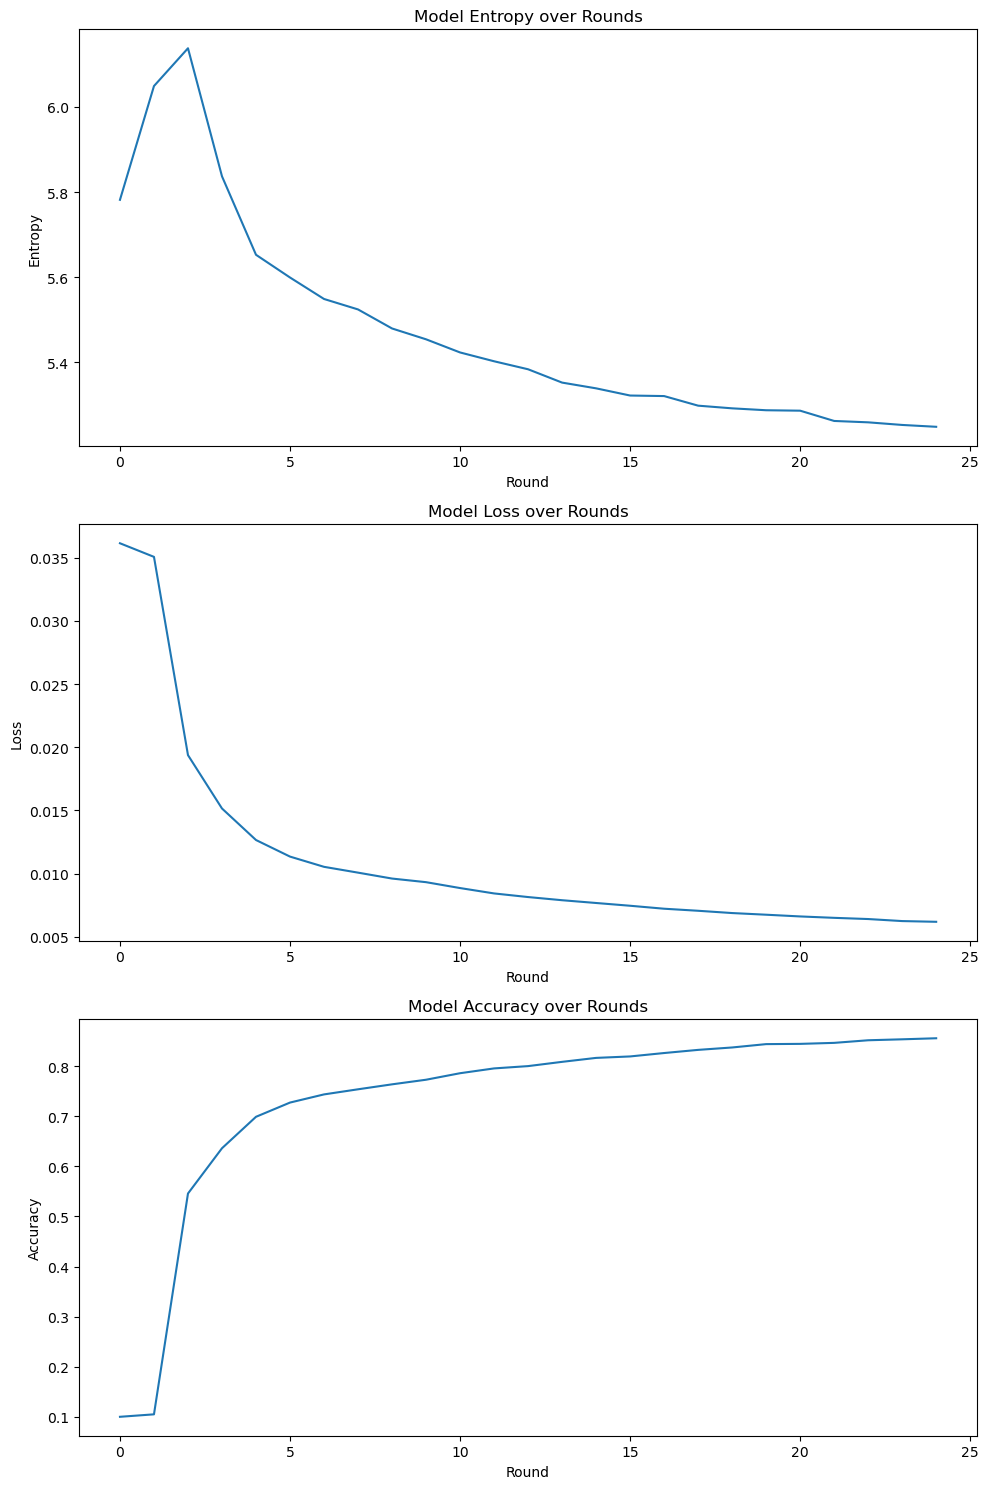

In [2]:
#FMNIST
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Definindo a rede neural LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, (2, 2))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, (2, 2))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Carregar e dividir o dataset FMNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloaders = torch.utils.data.random_split(trainset, [len(trainset)//10]*10)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Função para treinar um modelo em um cliente
def train_client(model, trainloader, epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Função para avaliar o modelo
def evaluate_model(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy

# Função para obter os parâmetros do modelo
def get_model_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]

# Função para definir os parâmetros do modelo
def set_model_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param, device=device)

# Função para calcular a entropia dos parâmetros do modelo
def calculate_entropy(parameters):
    flat_params = np.concatenate([p.flatten() for p in parameters])
    # Normalizar os parâmetros e adicionar um pequeno valor constante
    flat_params = flat_params / np.sum(np.abs(flat_params))
    flat_params = flat_params + 1e-10
    # Calcular a entropia
    flat_params = flat_params[flat_params > 0]  # Remover valores zero
    return -np.sum(flat_params * np.log(flat_params))

# Inicializar modelos e entropias
clients = [LeNet().to(device) for _ in range(10)]
entropies = []
losses = []
accuracies = []

# Executar o treinamento federado
num_rounds = 25
for rnd in range(num_rounds):
    print(f"Starting round {rnd+1}/{num_rounds}")
    client_parameters = []

    # Treinar cada cliente e coletar parâmetros
    for i, client in enumerate(clients):
        trainloader = torch.utils.data.DataLoader(trainloaders[i], batch_size=64, shuffle=True)
        train_client(client, trainloader)
        client_parameters.append(get_model_parameters(client))

    # Agregar parâmetros (média)
    avg_parameters = [np.mean([params[layer] for params in client_parameters], axis=0) for layer in range(len(client_parameters[0]))]

    # Calcular a entropia dos parâmetros agregados
    model_entropy = calculate_entropy(avg_parameters)
    entropies.append(model_entropy)
    
    # Definir os parâmetros agregados em cada cliente
    for client in clients:
        set_model_parameters(client, avg_parameters)
    
    # Avaliar o modelo agregado
    global_model = LeNet().to(device)
    set_model_parameters(global_model, avg_parameters)
    loss, accuracy = evaluate_model(global_model, testloader)
    losses.append(loss)
    accuracies.append(accuracy)
    
    print(f"Round {rnd+1} - Entropy: {model_entropy}, Loss: {loss}, Accuracy: {accuracy}")
    print(f"Completed round {rnd+1}/{num_rounds}")

# Plotar a entropia, perda e acurácia ao longo das rodadas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(entropies)
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Entropy')
axs[0].set_title('Model Entropy over Rounds')

axs[1].plot(losses)
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Loss over Rounds')

axs[2].plot(accuracies)
axs[2].set_xlabel('Round')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model Accuracy over Rounds')

plt.tight_layout()
plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Starting round 1/50
Round 1 - Entropy: 4.614566802978516, Loss: 0.03615969398021698, Accuracy: 0.1
Completed round 1/50
Starting round 2/50
Round 2 - Entropy: 5.323920249938965, Loss: 0.03330473749637604, Accuracy: 0.2359
Completed round 2/50
Starting round 3/50
Round 3 - Entropy: 5.875393390655518, Loss: 0.021070995593070983, Accuracy: 0.4963
Completed round 3/50
Starting round 4/50
Round 4 - Entropy: 5.799080848693848, Loss: 0.017344217908382416, Accuracy: 0.5991
Completed round 4/50
Starting round 5/50
Round 5 - Entropy: 5.719120502471924, Loss: 0.01561740419268608, Accuracy: 0.6474
Completed round 5/50
Starting round 6/50
Round 6 - Entropy: 5.645539283752441, Loss: 0.014803305295109748, Accuracy: 0.6832
Completed round 6/50
Starting round 7/50
Round 7 - Entropy: 5.598005294799805, Loss: 0.014803592798113822, Accuracy: 0.7055
Completed round 7/50
Starting round 8/50
Round 8 - Entropy: 5.57

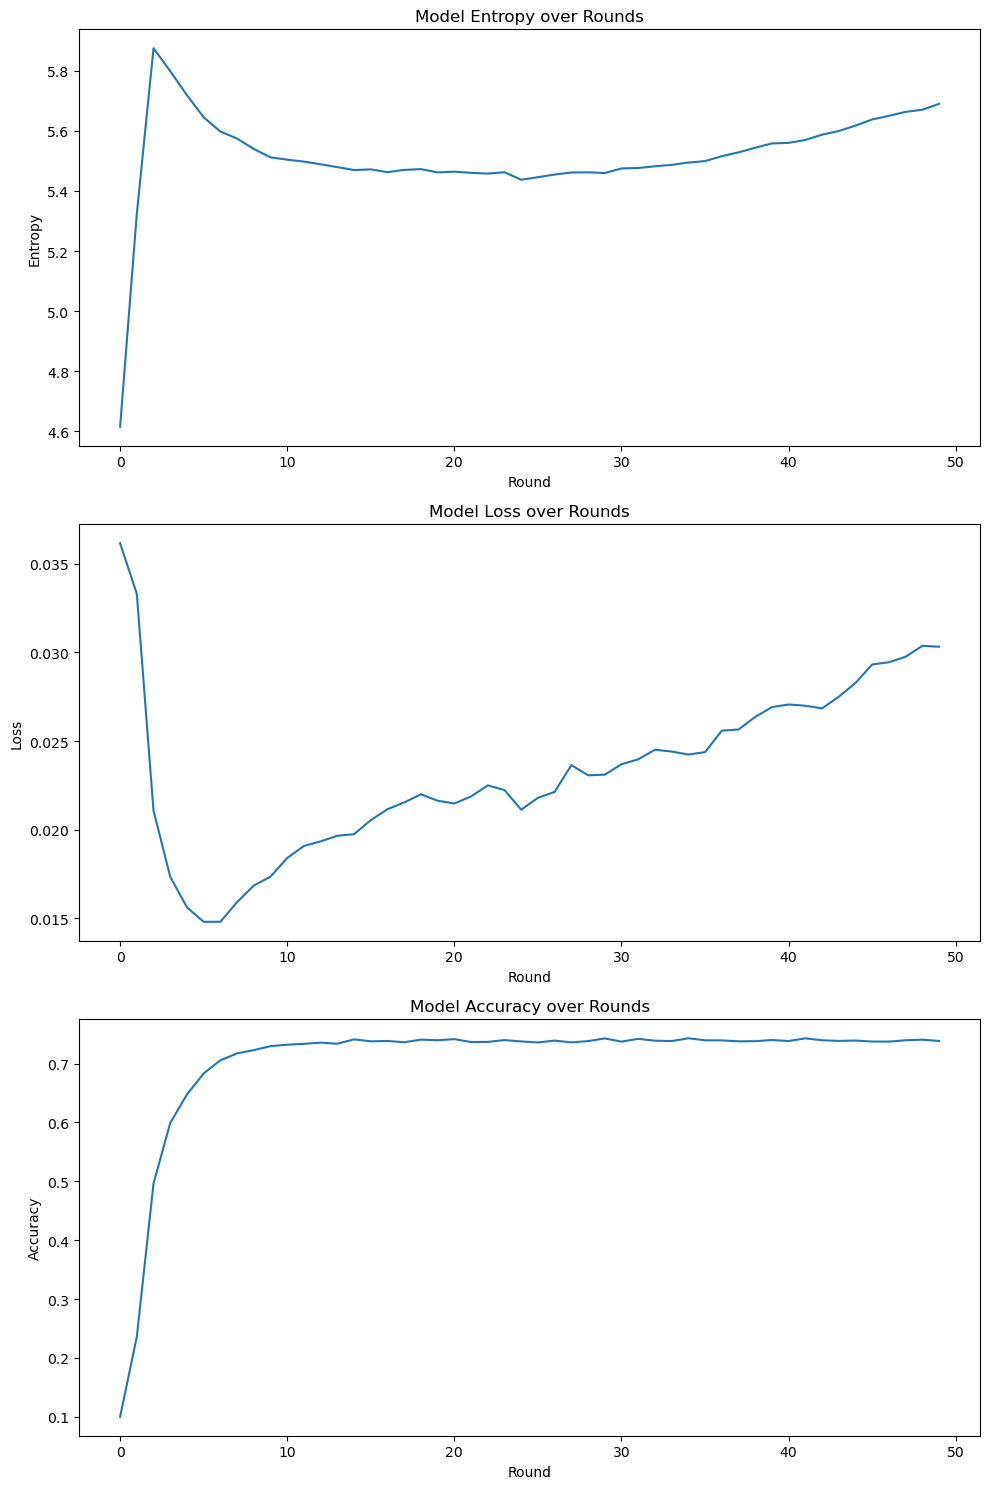

In [5]:
#CIFAR-10
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Definindo a rede neural LeNet adaptada para CIFAR-10
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Carregar e dividir o dataset CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloaders = torch.utils.data.random_split(trainset, [len(trainset)//10]*10)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Função para treinar um modelo em um cliente
def train_client(model, trainloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Função para avaliar o modelo
def evaluate_model(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy

# Função para obter os parâmetros do modelo
def get_model_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]

# Função para definir os parâmetros do modelo
def set_model_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param, device=device)

# Função para calcular a entropia dos parâmetros do modelo
def calculate_entropy(parameters):
    flat_params = np.concatenate([p.flatten() for p in parameters])
    # Normalizar os parâmetros e adicionar um pequeno valor constante
    flat_params = flat_params / np.sum(np.abs(flat_params))
    flat_params = flat_params + 1e-10
    flat_params = flat_params[flat_params > 0]  # Remover valores zero
    # Calcular a entropia
    return -np.sum(flat_params * np.log(flat_params))

# Inicializar modelos e entropias
clients = [LeNet().to(device) for _ in range(10)]
entropies = []
losses = []
accuracies = []

# Executar o treinamento federado
num_rounds = 50
for rnd in range(num_rounds):
    print(f"Starting round {rnd+1}/{num_rounds}")
    client_parameters = []

    # Treinar cada cliente e coletar parâmetros
    for i, client in enumerate(clients):
        trainloader = torch.utils.data.DataLoader(trainloaders[i], batch_size=64, shuffle=True)
        train_client(client, trainloader)
        client_parameters.append(get_model_parameters(client))

    # Agregar parâmetros (média)
    avg_parameters = [np.mean([params[layer] for params in client_parameters], axis=0) for layer in range(len(client_parameters[0]))]

    # Calcular a entropia dos parâmetros agregados
    model_entropy = calculate_entropy(avg_parameters)
    entropies.append(model_entropy)
    
    # Definir os parâmetros agregados em cada cliente
    for client in clients:
        set_model_parameters(client, avg_parameters)
    
    # Avaliar o modelo agregado
    global_model = LeNet().to(device)
    set_model_parameters(global_model, avg_parameters)
    loss, accuracy = evaluate_model(global_model, testloader)
    losses.append(loss)
    accuracies.append(accuracy)
    
    print(f"Round {rnd+1} - Entropy: {model_entropy}, Loss: {loss}, Accuracy: {accuracy}")
    print(f"Completed round {rnd+1}/{num_rounds}")

# Plotar a entropia, perda e acurácia ao longo das rodadas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(entropies)
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Entropy')
axs[0].set_title('Model Entropy over Rounds')

axs[1].plot(losses)
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Loss over Rounds')

axs[2].plot(accuracies)
axs[2].set_xlabel('Round')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model Accuracy over Rounds')

plt.tight_layout()
plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Starting round 1/50
Round 1 - Entropy: 4.172747611999512, Loss: 0.036159972071647645, Accuracy: 0.1
Completed round 1/50
Starting round 2/50
Round 2 - Entropy: 5.107730388641357, Loss: 0.030665483844280243, Accuracy: 0.2322
Completed round 2/50
Starting round 3/50
Round 3 - Entropy: 5.695481300354004, Loss: 0.019386767601966857, Accuracy: 0.5391
Completed round 3/50
Starting round 4/50
Round 4 - Entropy: 5.622307777404785, Loss: 0.015177611875534057, Accuracy: 0.6489
Completed round 4/50
Starting round 5/50
Round 5 - Entropy: 5.506723880767822, Loss: 0.012984638291597366, Accuracy: 0.707
Completed round 5/50
Starting round 6/50
Round 6 - Entropy: 5.405878067016602, Loss: 0.011698748707771302, Accuracy: 0.741
Completed round 6/50
Starting round 7/50
Round 7 - Entropy: 5.343592166900635, Loss: 0.010844754007458686, Accuracy: 0.761
Completed round 7/50
Starting round 8/50
Round 8 - Entropy: 5.29

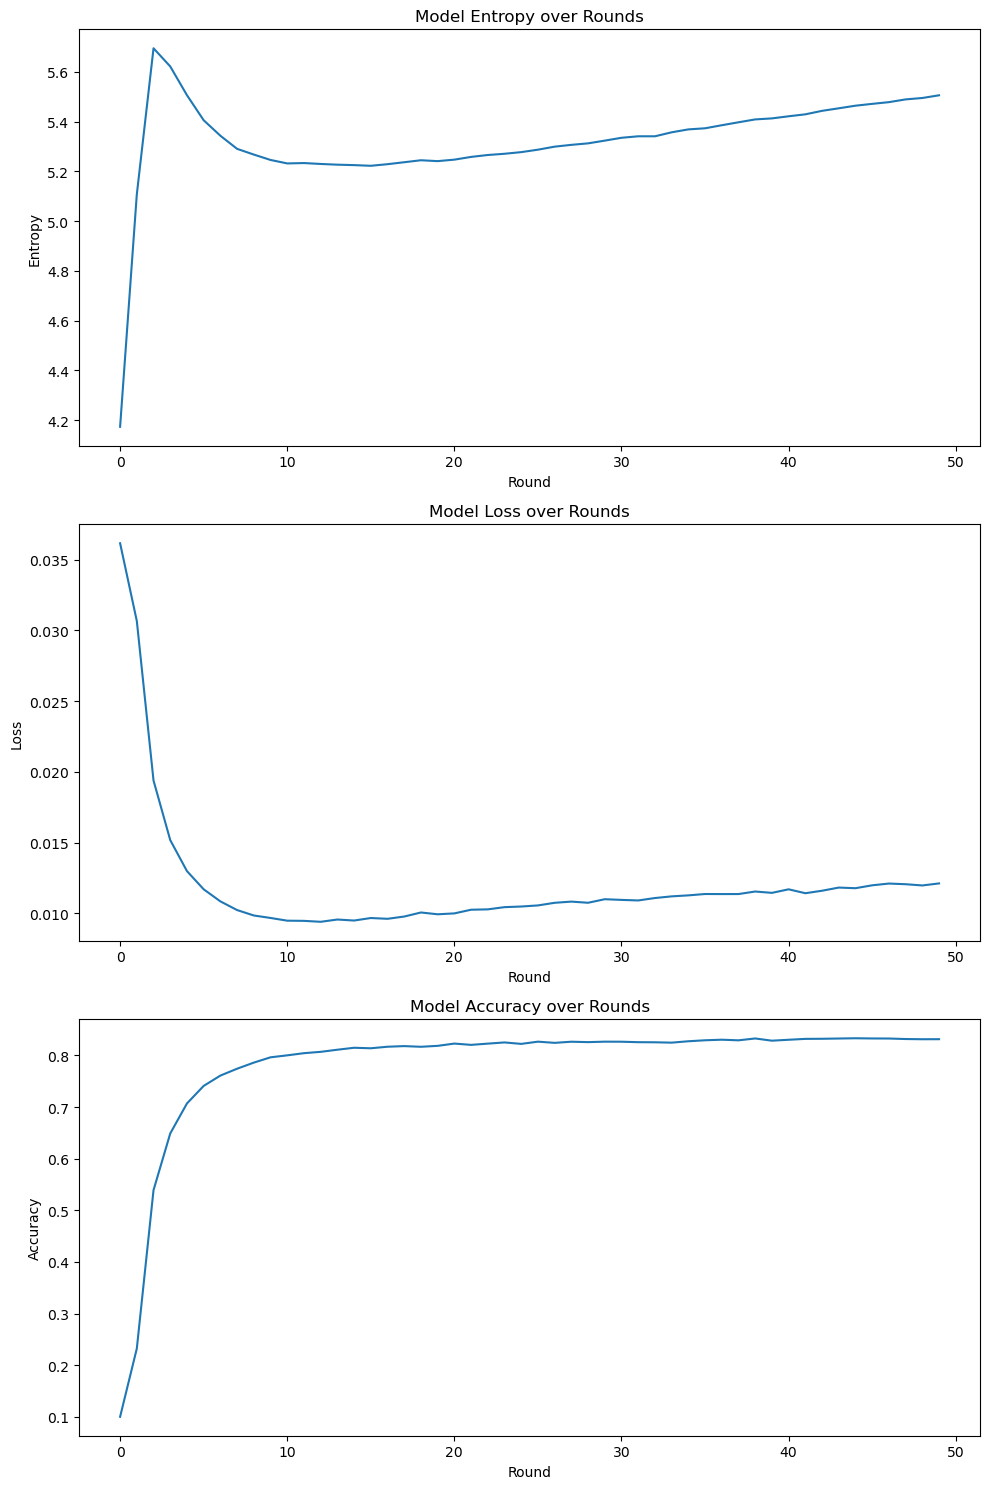

In [10]:
#CIFAR-10 Dados Melhorados
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Definindo a rede neural LeNet adaptada para CIFAR-10
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Carregar e dividir o dataset CIFAR-10 com data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloaders = torch.utils.data.random_split(trainset, [len(trainset)//10]*10)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Função para treinar um modelo em um cliente
def train_client(model, trainloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

# Função para avaliar o modelo
def evaluate_model(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy

# Função para obter os parâmetros do modelo
def get_model_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]

# Função para definir os parâmetros do modelo
def set_model_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param, device=device)

# Função para calcular a entropia dos parâmetros do modelo
def calculate_entropy(parameters):
    flat_params = np.concatenate([p.flatten() for p in parameters])
    # Normalizar os parâmetros e adicionar um pequeno valor constante
    flat_params = flat_params / np.sum(np.abs(flat_params))
    flat_params = flat_params + 1e-10
    flat_params = flat_params[flat_params > 0]  # Remover valores zero
    # Calcular a entropia
    return -np.sum(flat_params * np.log(flat_params))

# Inicializar modelos e entropias
clients = [LeNet().to(device) for _ in range(10)]
entropies = []
losses = []
accuracies = []

# Executar o treinamento federado
num_rounds = 50
for rnd in range(num_rounds):
    print(f"Starting round {rnd+1}/{num_rounds}")
    client_parameters = []

    # Treinar cada cliente e coletar parâmetros
    for i, client in enumerate(clients):
        trainloader = torch.utils.data.DataLoader(trainloaders[i], batch_size=64, shuffle=True)
        train_client(client, trainloader)
        client_parameters.append(get_model_parameters(client))

    # Agregar parâmetros (média)
    avg_parameters = [np.mean([params[layer] for params in client_parameters], axis=0) for layer in range(len(client_parameters[0]))]

    # Calcular a entropia dos parâmetros agregados
    model_entropy = calculate_entropy(avg_parameters)
    entropies.append(model_entropy)
    
    # Definir os parâmetros agregados em cada cliente
    for client in clients:
        set_model_parameters(client, avg_parameters)
    
    # Avaliar o modelo agregado
    global_model = LeNet().to(device)
    set_model_parameters(global_model, avg_parameters)
    loss, accuracy = evaluate_model(global_model, testloader)
    losses.append(loss)
    accuracies.append(accuracy)
    
    print(f"Round {rnd+1} - Entropy: {model_entropy}, Loss: {loss}, Accuracy: {accuracy}")
    print(f"Completed round {rnd+1}/{num_rounds}")

# Plotar a entropia, perda e acurácia ao longo das rodadas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(entropies)
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Entropy')
axs[0].set_title('Model Entropy over Rounds')

axs[1].plot(losses)
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Loss over Rounds')

axs[2].plot(accuracies)
axs[2].set_xlabel('Round')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model Accuracy over Rounds')

plt.tight_layout()
plt.show()

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Carregar e dividir o dataset CIFAR-10 com data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloaders = torch.utils.data.random_split(trainset, [len(trainset)//10]*10)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Função para obter um modelo ResNet-18 adaptado para CIFAR-10
def get_resnet_model():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

# Função para treinar um modelo em um cliente
def train_client(model, trainloader, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)  # Add weight_decay for regularization
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

# Função para avaliar o modelo
def evaluate_model(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy

# Função para obter os parâmetros do modelo
def get_model_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]

# Função para definir os parâmetros do modelo
def set_model_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param, device=device)

# Função para calcular a entropia dos parâmetros do modelo
def calculate_entropy(parameters):
    flat_params = np.concatenate([p.flatten() for p in parameters])
    # Normalizar os parâmetros e adicionar um pequeno valor constante
    flat_params = flat_params / np.sum(np.abs(flat_params))
    flat_params = flat_params + 1e-10
    flat_params = flat_params[flat_params > 0]  # Remover valores zero
    # Calcular a entropia
    return -np.sum(flat_params * np.log(flat_params))

# Inicializar modelos e entropias
clients = [get_resnet_model() for _ in range(10)]
entropies = []
losses = []
accuracies = []

# Executar o treinamento federado
num_rounds = 50
for rnd in range(num_rounds):
    print(f"Starting round {rnd+1}/{num_rounds}")
    client_parameters = []

    # Treinar cada cliente e coletar parâmetros
    for i, client in enumerate(clients):
        trainloader = torch.utils.data.DataLoader(trainloaders[i], batch_size=64, shuffle=True)
        train_client(client, trainloader)
        client_parameters.append(get_model_parameters(client))

    # Agregar parâmetros (média)
    avg_parameters = [np.mean([params[layer] for params in client_parameters], axis=0) for layer in range(len(client_parameters[0]))]

    # Calcular a entropia dos parâmetros agregados
    model_entropy = calculate_entropy(avg_parameters)
    entropies.append(model_entropy)
    
    # Definir os parâmetros agregados em cada cliente
    for client in clients:
        set_model_parameters(client, avg_parameters)
    
    # Avaliar o modelo agregado
    global_model = get_resnet_model()
    set_model_parameters(global_model, avg_parameters)
    loss, accuracy = evaluate_model(global_model, testloader)
    losses.append(loss)
    accuracies.append(accuracy)
    
    print(f"Round {rnd+1} - Entropy: {model_entropy}, Loss: {loss}, Accuracy: {accuracy}")
    print(f"Completed round {rnd+1}/{num_rounds}")

# Plotar a entropia, perda e acurácia ao longo das rodadas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].plot(entropies)
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Entropy')
axs[0].set_title('Model Entropy over Rounds')

axs[1].plot(losses)
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Loss over Rounds')

axs[2].plot(accuracies)
axs[2].set_xlabel('Round')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model Accuracy over Rounds')

plt.tight_layout()
plt.show()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Starting round 1/50
Round 1 - Entropy: 7.52972936630249, Loss: 0.03616975064277649, Accuracy: 0.1
Completed round 1/50
Starting round 2/50
Round 2 - Entropy: 6.769951820373535, Loss: 0.035536386346817016, Accuracy: 0.114
Completed round 2/50
Starting round 3/50
Round 3 - Entropy: 6.028713703155518, Loss: 19.235145385742186, Accuracy: 0.1595
Completed round 3/50
Starting round 4/50
Round 4 - Entropy: 6.142611980438232, Loss: 61.85678896484375, Accuracy: 0.1511
Completed round 4/50
Starting round 5/50
Round 5 - Entropy: 5.71762228012085, Loss: 250.05284755859375, Accuracy: 0.1258
Completed round 5/50
Starting round 6/50
Round 6 - Entropy: 6.017378330230713, Loss: 639.32401953125, Accuracy: 0.1384
Completed round 6/50
Starting round 7/50
Round 7 - Entropy: 5.583310604095459, Loss: 887.439699609375, Accuracy: 0.1275
Completed round 7/50
Starting round 8/50
Round 8 - Entropy: 5.886905670166016, Lo

KeyboardInterrupt: 

Using device: cuda
Starting round 1/25
Round 1 - Loss: 0.03615271625518799, Accuracy: 0.1
Completed round 1/25
Starting round 2/25
Round 2 - Loss: 0.021481116580963133, Accuracy: 0.46
Completed round 2/25
Starting round 3/25
Round 3 - Loss: 0.015368710488080979, Accuracy: 0.6144
Completed round 3/25
Starting round 4/25
Round 4 - Loss: 0.01277442380785942, Accuracy: 0.6939
Completed round 4/25
Starting round 5/25
Round 5 - Loss: 0.011454789704084397, Accuracy: 0.7258
Completed round 5/25
Starting round 6/25
Round 6 - Loss: 0.01067689022421837, Accuracy: 0.7399
Completed round 6/25
Starting round 7/25
Round 7 - Loss: 0.01022133464217186, Accuracy: 0.7476
Completed round 7/25
Starting round 8/25
Round 8 - Loss: 0.009811165618896485, Accuracy: 0.7572
Completed round 8/25
Starting round 9/25
Round 9 - Loss: 0.009358503320813179, Accuracy: 0.7746
Completed round 9/25
Starting round 10/25
Round 10 - Loss: 0.008982433369755745, Accuracy: 0.781
Completed round 10/25
Starting round 11/25
Round 1

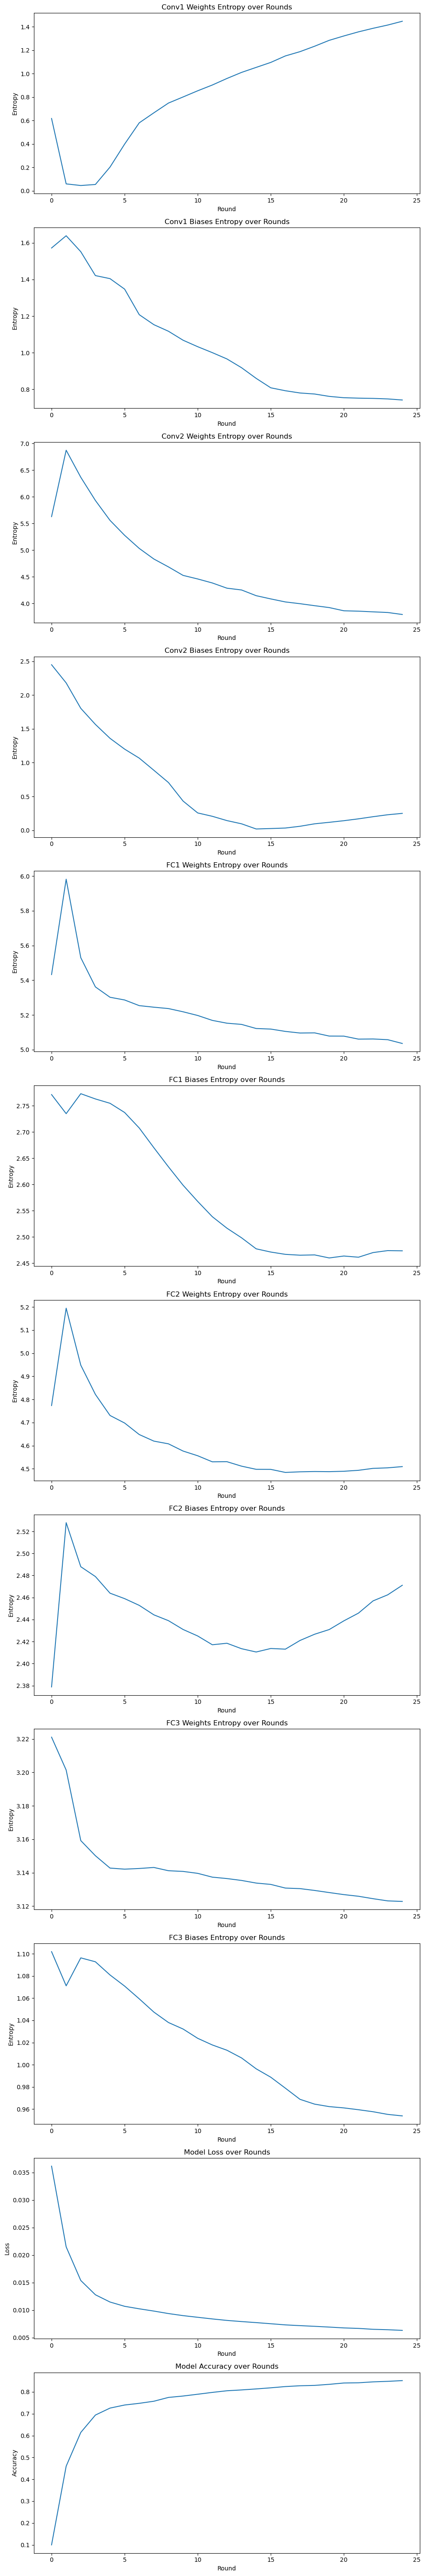

In [4]:
#Entropy of Layers

# FMNIST
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the LeNet neural network
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, (2, 2))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, (2, 2))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and split the FMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloaders = torch.utils.data.random_split(trainset, [len(trainset)//10]*10)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Function to train a model on a client
def train_client(model, trainloader, epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for epoch in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)
    return loss, accuracy

# Function to get the parameters of a model
def get_model_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]

# Function to set the parameters of a model
def set_model_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param, device=device)

# Function to calculate the entropy of a single layer's parameters
def calculate_layer_entropy(layer_parameters):
    flat_params = layer_parameters.flatten()
    flat_params = flat_params / np.sum(np.abs(flat_params))
    flat_params = flat_params + 1e-10
    flat_params = flat_params[flat_params > 0]
    return -np.sum(flat_params * np.log(flat_params))

# Initialize models and entropies
clients = [LeNet().to(device) for _ in range(10)]
layer_entropies = [[] for _ in range(len(get_model_parameters(clients[0])))]

losses = []
accuracies = []

# Run federated training
num_rounds = 25
for rnd in range(num_rounds):
    print(f"Starting round {rnd+1}/{num_rounds}")
    client_parameters = []

    # Train each client and collect parameters
    for i, client in enumerate(clients):
        trainloader = torch.utils.data.DataLoader(trainloaders[i], batch_size=64, shuffle=True)
        train_client(client, trainloader)
        client_parameters.append(get_model_parameters(client))

    # Aggregate parameters (mean)
    avg_parameters = [np.mean([params[layer] for params in client_parameters], axis=0) for layer in range(len(client_parameters[0]))]

    # Calculate entropy for each layer
    for layer_index, layer_params in enumerate(avg_parameters):
        layer_entropy = calculate_layer_entropy(layer_params)
        layer_entropies[layer_index].append(layer_entropy)

    # Set aggregated parameters in each client
    for client in clients:
        set_model_parameters(client, avg_parameters)

    # Evaluate the aggregated model
    global_model = LeNet().to(device)
    set_model_parameters(global_model, avg_parameters)
    loss, accuracy = evaluate_model(global_model, testloader)
    losses.append(loss)
    accuracies.append(accuracy)
    
    print(f"Round {rnd+1} - Loss: {loss}, Accuracy: {accuracy}")
    print(f"Completed round {rnd+1}/{num_rounds}")

# Plot entropy for each layer, loss, and accuracy over rounds
fig, axs = plt.subplots(len(layer_entropies) + 2, 1, figsize=(10, 5 * (len(layer_entropies) + 2)))

# Define layer names based on the network architecture
layer_names = [
    "Conv1 Weights", "Conv1 Biases",
    "Conv2 Weights", "Conv2 Biases",
    "FC1 Weights", "FC1 Biases",
    "FC2 Weights", "FC2 Biases",
    "FC3 Weights", "FC3 Biases"
]

for i, layer_entropy in enumerate(layer_entropies):
    axs[i].plot(layer_entropy)
    axs[i].set_xlabel('Round')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'{layer_names[i]} Entropy over Rounds')

axs[-2].plot(losses)
axs[-2].set_xlabel('Round')
axs[-2].set_ylabel('Loss')
axs[-2].set_title('Model Loss over Rounds')

axs[-1].plot(accuracies)
axs[-1].set_xlabel('Round')
axs[-1].set_ylabel('Accuracy')
axs[-1].set_title('Model Accuracy over Rounds')

plt.tight_layout()
plt.show()

